# Define the system  

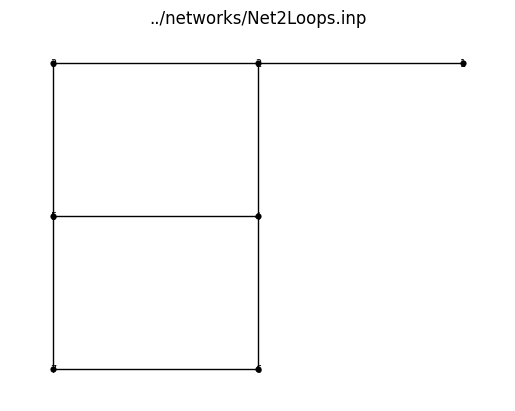

<Axes: title={'center': '../networks/Net2Loops.inp'}>

In [1]:
import wntr
import wntr_quantum

# Create a water network model
# inp_file = '../networks/Net0_HW.inp'
inp_file = '../networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Expression of he network

In [64]:
from wntr.sim.hydraulics import create_hydraulic_model
model, updater = create_hydraulic_model(wn, HW_approx='default')
print(model.__str__())


cons:
mass_balance[2]:   (((expected_demand[2]-flow[1])+flow[2])+flow[3])
mass_balance[3]:   ((expected_demand[3]-flow[2])+flow[7])
mass_balance[4]:   (((expected_demand[4]-flow[3])+flow[4])+flow[5])
mass_balance[5]:   (((expected_demand[5]-flow[4])-flow[7])+flow[8])
mass_balance[6]:   ((expected_demand[6]-flow[5])+flow[6])
mass_balance[7]:   ((expected_demand[7]-flow[6])-flow[8])
approx_hazen_williams_headloss[1]:   (((((((-((sign(flow[1]))))*hw_resistance[1])*((abs(flow[1]))**1.852))-((1e-05*(hw_resistance[1]**0.5))*flow[1]))-(((sign(flow[1]))*minor_loss[1])*(flow[1]**2.0)))+source_head[1])-head[2])
approx_hazen_williams_headloss[2]:   (((((((-((sign(flow[2]))))*hw_resistance[2])*((abs(flow[2]))**1.852))-((1e-05*(hw_resistance[2]**0.5))*flow[2]))-(((sign(flow[2]))*minor_loss[2])*(flow[2]**2.0)))+head[2])-head[3])
approx_hazen_williams_headloss[3]:   (((((((-((sign(flow[3]))))*hw_resistance[3])*((abs(flow[3]))**1.852))-((1e-05*(hw_resistance[3]**0.5))*flow[3]))-(((sign(flow[3]))*minor

In [63]:
list(model.cons())[0].

<method-wrapper '__str__' of Constraint object at 0x7005ef72e580>

In [3]:
print(model.expected_demand['J1'].value)
print(model.expected_demand['D1'].value)
print(model.hw_resistance['P1'].value)
print(model.hw_resistance['P2'].value)
print(model.source_head['R1'].value)

0.0
0.05
234518508.2718721
10512430570.450115
30.0


In [4]:
import numpy as np

hw_res = {'P1':1.0, 'P2':1.0}
exp_dem = {'J1':-1, 'D1':1}
src_hd = {'R1':2.0}

def network_function(input):
    
    flow = {'P1':input[0], 'P2':input[1]}
    head = {'J1':input[2], 'D1':input[3]}

    def mb_j1(flow):
        return exp_dem['J1'] - flow['P1'] + flow['P2']
    
    def mb_d1(flow):
        return exp_dem['D1'] - flow['P2']
    
    def hl_p1(head, flow):
        return -hw_res['P1']*flow['P1']**2 + src_hd['R1'] - head['J1']

    def hl_p2(head, flow):
        return -hw_res['P2']*flow['P2']**2 + head['J1'] - head['D1']
    
    return np.array([
        mb_j1(flow),
        mb_d1(flow),
        hl_p1(head, flow),
        hl_p2(head, flow)
    ])


In [5]:
from quantum_newton_raphson.newton_raphson import newton_raphson

initial_point = np.random.rand(4)
res = newton_raphson(network_function, initial_point)
assert np.allclose(network_function(res.solution), 0)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


In [6]:
res.solution

array([5.551e-17, 1.000e+00, 2.000e+00, 1.000e+00])

In [25]:
def define_problem():
    # system of equations
    num_equations = 4

    P0 = np.zeros(num_equations)
    P0[0] = exp_dem['J1']
    P0[1] = exp_dem['D1']
    P0[2] = src_hd['R1']
    P0[3] = 0

    P1 = np.zeros((num_equations, num_equations))
    P1[0, 0] = -1
    P1[0, 1] =  1
    P1[0, 2] =  0 
    P1[0, 3] =  0

    P1[1, 0] =  0
    P1[1, 1] = -1
    P1[1, 2] =  0 
    P1[1, 3] =  0

    P1[2, 0] =  0
    P1[2, 1] =  0
    P1[2, 2] = -1 
    P1[2, 3] =  0

    P1[3, 0] =  0
    P1[3, 1] =  0
    P1[3, 2] =  1 
    P1[3, 3] = -1
   

    P2 = np.zeros((num_equations, num_equations, num_equations))
    P2[2, 0, 0] = -hw_res['P1']
    P2[3, 1, 1] = -hw_res['P2']

    # search parameters
    qubits_per_var = 2
    basis = np.array([2**i for i in range(qubits_per_var)])

    # basis_offset = np.array([-0.5, 1])
    # basis_coeff = np.array([0.5, 1])

    basis_offset = np.array([0.0, 0.0, 0.0, 0.0])
    basis_coeff = np.array([1, 1, 1, 1])

    basis_map = {
        "basis": basis,
        "basis_offset": basis_offset,
        "basis_coeff": basis_coeff,
    }

    return (
        num_equations,
        P0,
        P1,
        P2,
        qubits_per_var,
        basis,
        basis_offset,
        basis_coeff,
        basis_map,
    )

In [26]:
from poly_brute_force import solve
sol = solve(define_problem)

extended qubo
ground state eigenvector =  [0. 0. 1. 0. 0. 1. 1. 0.]
ground state eigenvalue  =  0.0
solution                 =  [0.0, 1.0, 2.0, 1.0]

upper triangular qubo
ground state eigenvector =  [0. 0. 1. 0. 0. 1. 1. 0.]
ground state eigenvalue  =  0.0
solution                 =  [0.0, 1.0, 2.0, 1.0]

reduced upper triangular qubo
ground state eigenvector =  [0. 0. 1. 0. 0. 1. 1. 0.]
ground state eigenvalue  =  0.0
solution                 =  [0.0, 1.0, 2.0, 1.0]

